<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/39/VU_logo.png/800px-VU_logo.png?20161029201021" width="350">

### Programming large-scale parallel systems

# Gaussian elimination

## Contents

In this notebook, we will learn

- How to parallelize Gaussian elimination
- How to fix static load imbalance

<div class="alert alert-block alert-info">
<b>Note:</b> Do not forget to execute the cell below before starting this notebook! 
</div>

In [1]:
using Printf
function answer_checker(answer,solution)
    if answer == solution
        "🥳 Well done! "
    else
        "It's not correct. Keep trying! 💪"
    end |> println
end
ge_par_check(answer) = answer_checker(answer, "a")
ge_dep_check(answer) = answer_checker(answer, "b")

ge_dep_check (generic function with 1 method)

## Gaussian elimination


[Gaussian elimination](https://en.wikipedia.org/wiki/Gaussian_elimination) is a method to solve systems of linear equations, e.g.

$$
\left[
\begin{matrix}
1 & 3 & 1 \\
1 & 2 & -1 \\
3 & 11 & 5 \\
\end{matrix}
\right]
\left[
\begin{matrix}
x \\
y \\
z  \\
\end{matrix}
\right]
=
\left[
\begin{matrix}
9 \\
1 \\
35  \\
\end{matrix}
\right]
$$

The steps of the Gaussian elimination will transform the system into an upper triangular matrix. The system of linear equations can now easily be solved by backward substitution. 


$$
\left[
\begin{matrix}
1 & 3 & 1 & 9 \\
1 & 2 & -1 & 1 \\
3 & 11 & 5 & 35 \\
\end{matrix}
\right]
\rightarrow
\left[
\begin{matrix}
1 & 3 & 1 & 9 \\
0 & -1 & -2 & -8 \\
0 & 2 & 2 & 8 \\
\end{matrix}
\right]
\rightarrow
\left[
\begin{matrix}
1 & 3 & 1 & 9 \\
0 & 1 & 2 & 8 \\
0 & 2 & 2 & 8 \\
\end{matrix}
\right]
\rightarrow
\left[
\begin{matrix}
1 & 3 & 1 & 9 \\
0 & 1 & 2 & 8 \\
0 & 0 & -2 & -8 \\
\end{matrix}
\right]
\rightarrow
\left[
\begin{matrix}
1 & 3 & 1 & 9 \\
0 & 1 & 2 & 8 \\
0 & 0 & 1 & 4 \\
\end{matrix}
\right]
$$



### Serial implementation
The following algorithm computes the Gaussian elimination on a matrix which represents a system of linear equations.
- The first inner loop in line 4 divides the current row by the value of the diagonal entry, thus transforming the diagonal to contain only ones. 
- The second inner loop beginning in line 8 substracts the rows from one another such that all entries below the diagonal become zero. 

In [1]:
function gaussian_elimination!(B)
    n,m = size(B)
    @inbounds for k in 1:n
        for t in (k+1):m
            B[k,t] =  B[k,t]/B[k,k]
        end
        B[k,k] = 1
        for i in (k+1):n 
            for j in (k+1):m
                B[i,j] = B[i,j] - B[i,k]*B[k,j]
            end
            B[i,k] = 0
        end
    end
    B
end

gaussian_elimination! (generic function with 1 method)

<div class="alert alert-block alert-info">
<b>Note:</b> This algorithm is not correct for all matrices: if any diagonal element <code>B[k,k]</code> is zero, the computation in the first inner loop fails. To get around this problem, another step can be added to the algorithm that swaps the rows until the diagonal entry of the current row is not zero. This process of finding a nonzero value is called <b>pivoting</b>.   
</div>

In [2]:
A = Float64[1 3 1; 1 2 -1; 3 11 5]
b = Float64[9,1,35]
B = [A b]
gaussian_elimination!(B)

3×4 Matrix{Float64}:
 1.0  3.0  1.0  9.0
 0.0  1.0  2.0  8.0
 0.0  0.0  1.0  4.0

The result is an upper triangular matrix which can be used to solve the system by backward substitution. 

## Parallelization


### Where can we extract parallelism?

```julia
n,m = size(B)
for k in 1:n
    for t in (k+1):m
        B[k,t] =  B[k,t]/B[k,k]
    end
    B[k,k] = 1
    for i in (k+1):n 
        for j in (k+1):m
            B[i,j] = B[i,j] - B[i,k]*B[k,j]
        end
        B[i,k] = 0
    end
end
```

<div class="alert alert-block alert-success">
<b>Question:</b>  Which of the loops can be parallelized?
</div>

    a) the inner loops, but not the outer loop
    b) the outer loop, but not the inner loops
    c) all loops
    d) only the first inner loop

In [5]:
answer = "x" # replace x with a, b, c, or d 
ge_par_check(answer)

It's not correct. Keep trying! 💪


### Two possible data partitions

The outer loop of the algorithm is not parallelizable, since the iterations depend on the results of the previous iterations. However, we can extract parallelism from the inner loops. Let's have a look at two different parallelization schemes. 

1. **Block-wise partitioning**: Each processor gets a block of subsequent rows. 
2. **Cyclic partitioning**: The rows are cyclicly distributed among the processors. 

<div>
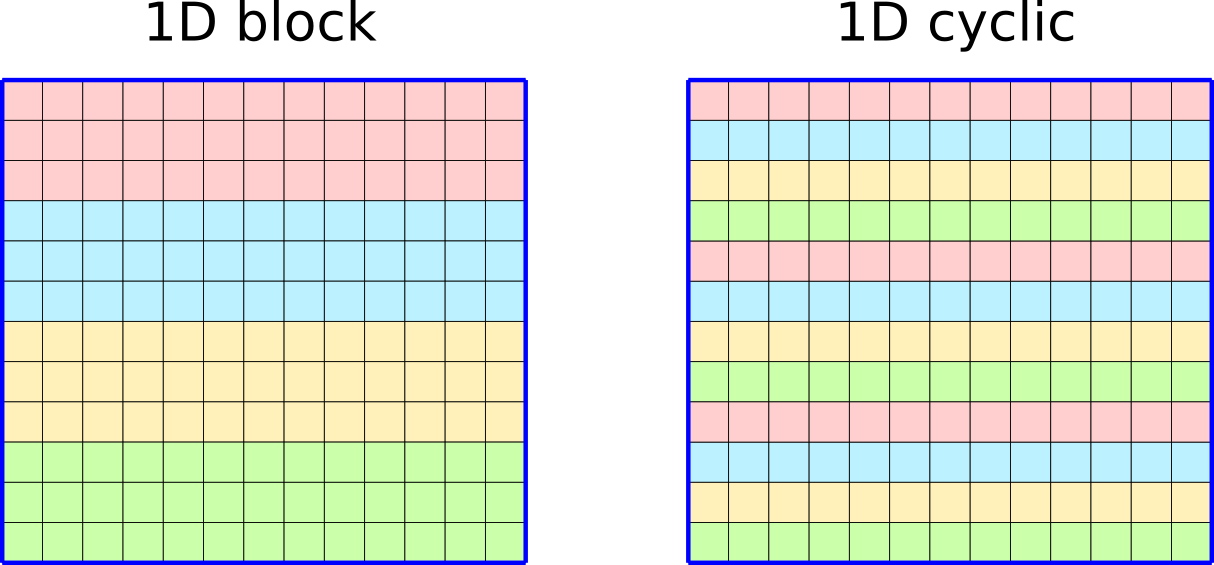
</div>

## What is the work per process at iteration k?
To evaluate the efficiency of both partitioning schemes, consider how much work the processors do in the following example. 
In any iteration k, which part of the matrix is updated in the inner loops? 

<div>
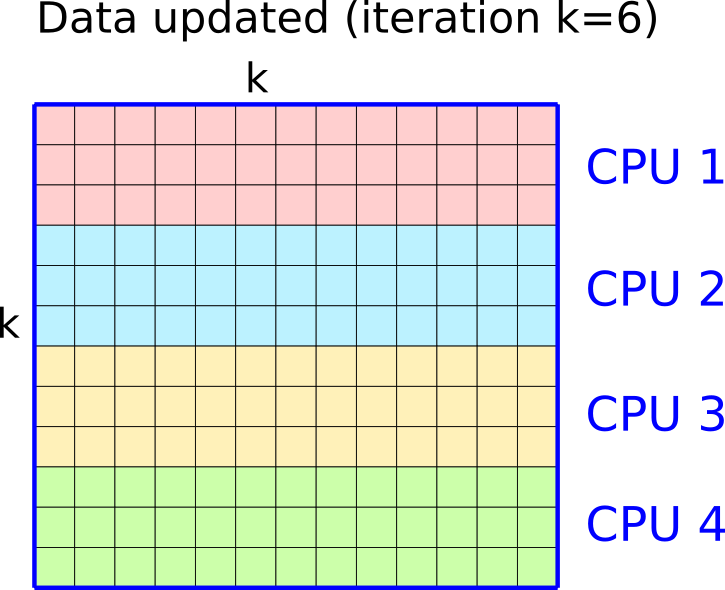
</div>

It is clear from the code that at a given iteration `k`, the matrix is updated from row `k` to `n` and from column `k` to `m`. If we look at how that reflects the distribution of work over the processes, we can see that CPU 1 does not have any work, whereas CPU 2 does a little work and CPU 3 and 4 do a lot of work. Thus, the work load is _imbalanced_ across the different processes. 

<div>
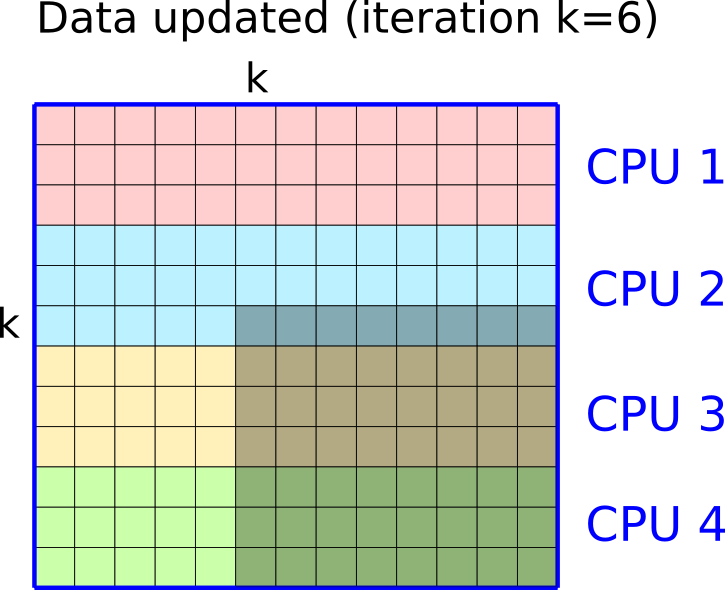
</div>

### Load imbalance

- CPUs with rows <k are idle during iteration k
- Bad load balance means bad speedups, as some CPUs are waiting instead of doing useful work
- Solution: cyclic partition  
                    
### Data dependencies
                    
<div class="alert alert-block alert-success">
<b>Question:</b>  What are the data dependencies of this partitioning?
</div>

    a) CPUs with rows >k need all rows <=k
    b) CPUs with rows >k need part of row k
    c) All CPUs need row k 
    d) CPUs with row k needs all rows >k  


In [4]:
answer = "x" # replace x with a, b, c, or d 
ge_dep_check(answer)

It's not correct. Keep trying! 💪


### Cyclic partition

In contrast, if we look at how the work is balanced for the same example and cyclic partitioning, we find that the processes have similar work load. 

<div>
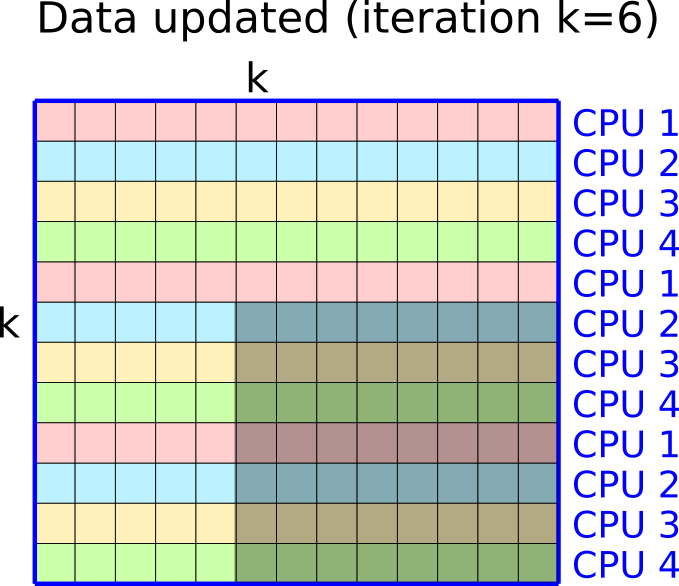
</div>

## Conclusion
Cyclic partitioning tends to work well in problems with predictable load imbalance. It is a form of **static load balancing** which means using a pre-defined load schedule based on prior information about the algorithm (as opposed to **dynamic load balancing** which can schedule loads more flexibly during runtime). The data dependencies are the same as for the 1d block partitioning.

At the same time, cyclic partitioning is not suitable for all communication patterns. For example, it can lead to a large communication overhead in the parallel Jacobi method, since the computation of each value depends on its neighbouring elements.

## Exercise
The actual implementation of the parallel algorithm is left as an exercise. Implement both 1d block and 1d cyclic partitioning and compare their performance. The implementation is closely related to that of Floyd's algorithm. To test your algorithms, generate input matrices with the function below (a random matrix is not enough, we need a non singular matrix that does not require pivoting). 

In [5]:
function tridiagonal_matrix(n)
    C = zeros(n,n)
    stencil = [(-1,2,-1),(-1,0,1)]
    for i in 1:n
        for  (coeff,o) in zip((-1,2,-1),(-1,0,1))
            j = i+o
            if j in 1:n
                C[i,j] = coeff
            end
        end
    end
    C
end

tridiagonal_matrix (generic function with 1 method)

In [ ]:
n = 5
C = tridiagonal_matrix(n)
b = ones(n)
gaussian_elimination!(C)